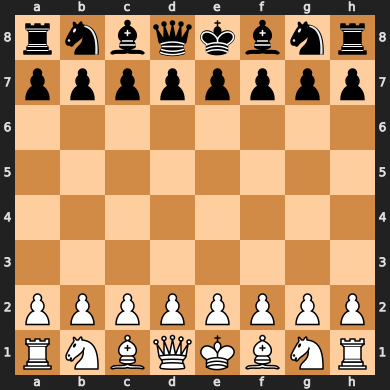

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import chess
import chess.engine
import chess.pgn
import chess.svg
from IPython.display import *
import datetime 


engine = chess.engine.SimpleEngine.popen_uci(r"C:\ThefCraft\global-env-exe\stockfish\stockfish-windows-x86-64-avx2.exe")
board = chess.Board()
board

In [2]:
from utils.board import board2vec

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from io import StringIO 

import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import os

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [154]:
df = pd.read_csv('lichess_100mb/lichess_100mb.csv')
df

,Unnamed: 0,WhiteElo,BlackElo,Result,transcript
0,33733,1554,1522,0-1,1.e4 d6 2.Bc4 Nf6 3.Qf3 g6 4.d3 Bg7 5.c3 O-O 6...
1,83900,1915,2065,1/2-1/2,1.d4 Nf6 2.c4 e6 3.Nc3 b6 4.Nf3 Bb7 5.a3 Ne4 6...
2,45565,2101,2114,0-1,1.e4 g6 2.d4 Bg7 3.Nc3 c5 4.Be3 cxd4 5.Bxd4 Nf...
3,18791,1813,1788,0-1,1.e4 g6 2.f4 Bg7 3.d4 d6 4.c4 Nf6 5.Nc3 O-O 6....
4,86451,1823,1927,1-0,1.e4 e5 2.Nf3 Nc6 3.d4 exd4 4.Nxd4 Bc5 5.Nb3 B...
...,...,...,...,...,...
263869,2621868,1664,1689,1-0,1.d4 e6 2.Bf4 c6 3.Nf3 d5 4.e3 Bd6 5.Bxd6 Qxd6...
263870,2692262,1728,1784,1-0,1.d4 c5 2.d5 d6 3.c4 e5 4.e4 Na6 5.a3 Bd7 6.Nc...
263871,2634235,1711,1707,1-0,1.e4 d6 2.d4 Nc6 3.d5 Ne5 4.Nc3 Nf6 5.h3 e6 6....
263872,2640298,1901,1719,1-0,1.e4 c5 2.Nc3 Nc6 3.Nf3 e6 4.Bb5 d5 5.Bxc6+ bx...


# DATASET

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, size = 100):
#         df = pd.read_csv('lichess_100mb/lichess_100mb.csv')
#         self.X = []
#         self.Y = []
#         # Iterate over the DataFrame and analyze each game
#         for index, row in tqdm(df.iterrows(), total = df.__len__()):
#             if (index>=size): break
#             moves = row['transcript']
#             board = chess.Board()

#             pgn = StringIO(moves) 
#             game = chess.pgn.read_game(pgn) 

#             for number, move in enumerate(game.mainline_moves()): 
#                 self.X.append(board2vec(board))
#                 who = F.one_hot(torch.tensor(move.from_square), 64).float()
#                 where = F.one_hot(torch.tensor(move.to_square), 64).float()
#                 self.Y.append((who, where))
#                 board.push(move)
#             pgn.close()
#         assert(len(self.X)==len(self.Y))
        
#     def __len__(self): return len(self.X)

#     def __getitem__(self, idx): return self.X[idx], self.Y[idx]

    
# # Create an instance of the custom dataset
# custom_dataset = CustomDataset(size=128*128)

In [266]:
class CustomDataset(Dataset):
    def __init__(self, file='chess_dataset_1000.npz'):
        # Load the dataset
        loaded_data = np.load(file)
        # Extract the arrays
        self.X_position8x8 = loaded_data['X_position8x8'].astype(np.float32)
        self.X_attack8x8 = loaded_data['X_attack8x8'].astype(np.float32)
        self.X_current_player = loaded_data['X_current_player'].astype(np.float32)
        self.X_castling_rights = loaded_data['X_castling_rights'].astype(np.float32)
        self.X_en_passant_square = loaded_data['X_en_passant_square'].astype(np.float32)
        self.Y_who = loaded_data['Y_who'].astype(np.float32)
        self.Y_where = loaded_data['Y_where'].astype(np.float32)
        
    def __len__(self): return len(self.X_position8x8)
    def __getitem__(self, idx): 
        return (self.X_position8x8[idx], self.X_attack8x8[idx], self.X_current_player[idx], self.X_castling_rights[idx], self.X_en_passant_square[idx],
                self.Y_who[idx], self.Y_where[idx])

    
# Create an instance of the custom dataset
custom_dataset = CustomDataset(file='chess_dataset_1000_black.npz')

In [28]:
# Create a DataLoader with batch size 64
batch_size = 4
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
# # Iterate through the DataLoader
for batch in data_loader:
    position, attacks, current_player, castling_rights, en_passant_square, who, where = batch
    break

In [143]:
position, attacks, current_player, castling_rights, en_passant_square = board2vec(board)

# (batch_size, channels, height, width)

position = torch.from_numpy(position).unsqueeze(0)
attacks = torch.from_numpy(attacks).unsqueeze(0)

current_player = torch.from_numpy(current_player).unsqueeze(0)
castling_rights = torch.from_numpy(castling_rights).unsqueeze(0)
en_passant_square = torch.from_numpy(en_passant_square).unsqueeze(0)

position.shape, attacks.shape, current_player.shape, castling_rights.shape, en_passant_square.shape

(torch.Size([1, 8, 8]),
 torch.Size([1, 8, 8]),
 torch.Size([1, 1]),
 torch.Size([1, 4]),
 torch.Size([1, 64]))

In [92]:
en_passant_square

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# MODEL

In [269]:
class ChessModel(nn.Module):
    def __init__(self, force_learning=.5):
        super(ChessModel, self).__init__()
        
        self.conv_position = nn.Conv2d(1, 16, 3, padding=1)
        self.conv_attacks = nn.Conv2d(1, 16, 3, padding=1)
        
        self.fc_position_attack = nn.Linear(2*16*8*8, 12*12)
        
        # Max pooling layer
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        
        self.fc_other_info = nn.Linear(69, 144)
        self.fc1_main_who = nn.Linear(2*144, 512)
        self.fc1_main_where = nn.Linear(2*144, 512)
        self.fc2_who = nn.Linear(512, 8*8)
        self.fc2_where = nn.Linear(8*8+512, 8*8)
        
        self.force_learning = force_learning
    
    def forward(self, position, attacks, current_player, castling_rights, en_passant_square, targetwho=None, targetwhere=None):
        N = position.size(0)
        position = position.unsqueeze(1)
        attacks = attacks.unsqueeze(1)
        position = F.relu(self.conv_position(position))
        attacks = F.relu(self.conv_attacks(attacks))
        
        position_attack = F.relu(self.fc_position_attack(torch.concat((position, attacks), dim=1).view(N, -1)))
        other_info = F.relu(self.fc_other_info(torch.concat((current_player, castling_rights, en_passant_square), dim=1)))
        x=torch.concat((position_attack, other_info), dim=1)
        x_who = F.relu(self.fc1_main_who(x))
        x_where = F.relu(self.fc1_main_where(x))
        who = self.fc2_who(x_who)
        
        if targetwho is not None:
            if random.random()>self.force_learning:
                where = self.fc2_where(torch.concat((F.one_hot(torch.argmax(who, dim=1), 64), x_where), dim=1))
            else:    
                where = self.fc2_where(torch.concat((targetwho, x_where), dim=1))
        else:
            where = self.fc2_where(torch.concat((F.one_hot(torch.argmax(who, dim=1), 64), x_where), dim=1))
        return who, where

In [271]:
for (position, attacks, current_player, castling_rights, en_passant_square, targetwho, targetwhere) in dataloader: break

In [272]:
ChessModel()(position, attacks, current_player, castling_rights, en_passant_square, targetwho, targetwhere)[0]

tensor([[-3.2687e-02, -2.3239e-02,  6.8189e-02,  ...,  6.9901e-02,
         -4.0957e-02,  2.8127e-03],
        [-3.4715e-02, -3.3772e-02,  6.5322e-02,  ...,  6.3745e-02,
         -3.2770e-02,  6.9300e-03],
        [-2.0478e-02, -1.6929e-02,  6.3618e-02,  ...,  5.5279e-02,
         -3.8801e-02, -3.1723e-03],
        ...,
        [-2.5654e-02, -7.7991e-03,  7.3790e-02,  ...,  5.7096e-02,
         -4.3084e-02, -4.8411e-04],
        [-1.9992e-02, -1.5517e-02,  6.7006e-02,  ...,  6.2181e-02,
         -4.1513e-02, -2.7302e-05],
        [-3.4034e-02, -3.4189e-02,  6.3581e-02,  ...,  7.3608e-02,
         -4.8081e-02,  5.6040e-03]], grad_fn=<AddmmBackward0>)

In [284]:
EPOCH = 1000
BATCH_SIZE = 4096*4 # i update model weight after each iteration on batch size so make it larger
LR = .4#0.1

In [274]:
model = ChessModel(force_learning=.75).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR) # Adam ?

In [279]:
dataloader = DataLoader(custom_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [280]:
def calculate_accuracy(predictions, targets):
    with torch.no_grad():
        # Assuming predictions and targets are torch tensors
        predictions = predictions.argmax(dim=1)
        targets = targets.argmax(dim=1)
        correct = (predictions == targets).sum().item()
        total = targets.size(0)
        accuracy = correct / total
    return accuracy

In [286]:
model.train()
for epoch in range(EPOCH):
    for idx, (position, attacks, current_player, castling_rights, en_passant_square, targetwho, targetwhere) in enumerate(dataloader):
        optimizer.zero_grad()
        position, attacks, current_player, castling_rights, en_passant_square = position.to(device), attacks.to(device), current_player.to(device), castling_rights.to(device), en_passant_square.to(device)
        targetwho, targetwhere = targetwho.to(device), targetwhere.to(device)
        who, where = model(position, attacks, current_player, castling_rights, en_passant_square)#, targetwho, targetwhere)
        loss1 = criterion(who, targetwho)  # Targets1 are the ground truth labels for output1
        loss2 = criterion(where, targetwhere)  # Targets2 are the ground truth labels for output2
        total_loss = loss1# + loss2
        total_loss.backward()
        optimizer.step()
        if idx%50 == 0:
            # Calculate accuracy
            with torch.no_grad():
                who, where = model(position, attacks, current_player, castling_rights, en_passant_square)
            accuracy_who = calculate_accuracy(who, targetwho)
            accuracy_where = calculate_accuracy(where, targetwhere)
            print(f"{epoch} : Accuracy (From): {accuracy_who * 100:.2f}% | Accuracy (To): {accuracy_where * 100:.2f}% | total loss = {total_loss}")

0 : Accuracy (From): 17.78% | Accuracy (To): 11.34% | total loss = 1.9561371803283691
1 : Accuracy (From): 9.69% | Accuracy (To): 5.41% | total loss = 5.879417419433594
2 : Accuracy (From): 18.77% | Accuracy (To): 7.51% | total loss = 3.883880376815796
3 : Accuracy (From): 20.88% | Accuracy (To): 8.38% | total loss = 3.6829352378845215
4 : Accuracy (From): 24.62% | Accuracy (To): 8.94% | total loss = 3.4889235496520996
5 : Accuracy (From): 28.45% | Accuracy (To): 9.36% | total loss = 3.2615060806274414
6 : Accuracy (From): 30.02% | Accuracy (To): 9.43% | total loss = 3.0106167793273926
7 : Accuracy (From): 23.50% | Accuracy (To): 8.83% | total loss = 2.851510763168335
8 : Accuracy (From): 24.22% | Accuracy (To): 9.64% | total loss = 3.383913516998291
9 : Accuracy (From): 27.80% | Accuracy (To): 10.23% | total loss = 2.8933167457580566
10 : Accuracy (From): 28.57% | Accuracy (To): 10.26% | total loss = 2.7485477924346924
11 : Accuracy (From): 28.06% | Accuracy (To): 10.58% | total loss 

KeyboardInterrupt: 

In [300]:
def predict(model, board:chess.Board, forceRight=True)->chess.Move:
    position, attacks, current_player, castling_rights, en_passant_square = board2vec(board)
    position = torch.from_numpy(position).unsqueeze(0).to(device)
    attacks = torch.from_numpy(attacks).unsqueeze(0).to(device)

    current_player = torch.from_numpy(current_player).unsqueeze(0).to(device)
    castling_rights = torch.from_numpy(castling_rights).unsqueeze(0).to(device)
    en_passant_square = torch.from_numpy(en_passant_square).unsqueeze(0).to(device)
    with torch.no_grad():
        who, where = model(position, attacks, current_player, castling_rights, en_passant_square)
    who = who.squeeze().cpu().numpy()
    where = where.squeeze().cpu().numpy()

    if forceRight:
        who_possible = np.zeros(64, dtype=np.float32)
        who_possible[list(set([i.from_square for i in board.legal_moves]))] = 1
        who = who*who_possible
        who = who.argmax().item()
        
        where_possible = np.zeros(64, dtype=np.float32)
        where_possible[[i.to_square for i in board.legal_moves if i.from_square==who]] = 1
        where = where*where_possible
        where = where.argmax().item()
    else:
        who,where = who.argmax().item(), where.argmax().item()
    
    f,t = chess.square_name(who), chess.square_name(where)
    return chess.Move.from_uci(f + t)
predict(model, board, forceRight=True)

Move.from_uci('e7f6')

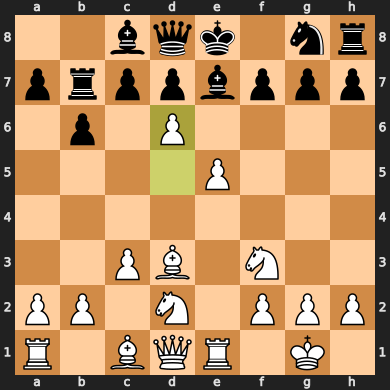

In [299]:
board

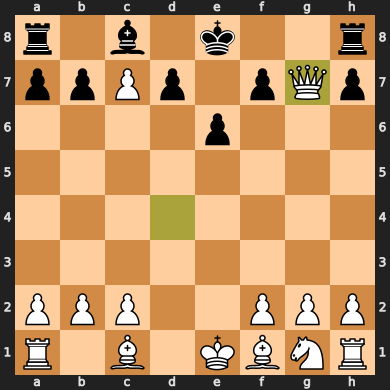

KeyboardInterrupt: 

In [301]:
matches = 0
while True:
    matches+=1
    movehistory =[]
    board.reset()
    game = chess.pgn.Game()
    game.headers["Event"] = "MakeDataset"
    game.headers["Site"] = "ThefCraft"
    game.headers["Date"] = str(datetime.datetime.now().date())
    game.headers["Round"] = matches
    game.headers["White"] = "Stockfish-1"
    game.headers["Black"] = "Stockfish-2"
    
    print('*'*50, 'Matches : ', matches, '*'*50)

    while not board.is_game_over():
        clear_output(wait=True)
        display(board)
        time.sleep(.5)
        if board.turn:
            move = engine.play(board, chess.engine.Limit(time=.000000001)).move
            movehistory.append(move)
            board.push(move)
        else:
            move = predict(model, board, forceRight=True)
            movehistory.append(move)
            board.push(move)

    break

game.add_line(movehistory)
game.headers["Result"] = str(board.result())
print(game)
print(game, file=open("test.pgn", "w"), end="\n\n")
SVG(chess.svg.board(board=board,size=400))

In [66]:
move = predict(model, board, forceRight=True)
move

Move.from_uci('e5e4')

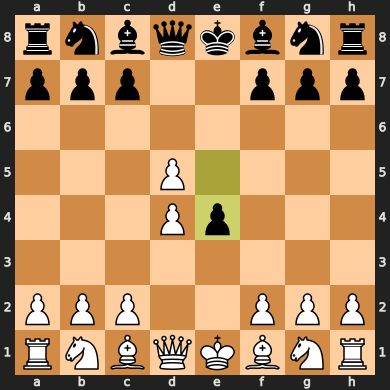

In [67]:
board.push(move)
board